# Brief illustration of transmit phase dependence

In [2]:
import sys
sys.path.append('/Users/sstk4353/packages/.')

from WIPL_python_analysis.SinglePolPlots import SinglePolPlots
from WIPL_python_analysis.DualPol import DualPol
from WIPL_python_analysis.DictToSinglePolResults import OutputDictToSinglePolResultsConverter as converter
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./')

In [3]:
BASE_DRIVE_PATH = '/Users/sstk4353/Library/CloudStorage/GoogleDrive-thomas.matthews@ncas.ac.uk/My Drive/WIPL/Bernard_ellipsoid_comparison/'
BERNARD_PATH = 'Bernard/'
ELLIPSOID_PATH = 'Ellipsoid/'

In [4]:
scale = '1000'
morpho = 'body'
wing_pos = 'M'
pol_list = ['H', 'V']
frequency_name = '560'
pol='H'
H_B = pd.read_csv(BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/csv/size_analysis_056/Bernard_parameterised_{frequency_name}_{pol}_{wing_pos}_{scale}_{morpho}_p0_s0_df.csv')
pol = 'V'
H_V = pd.read_csv(BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/csv/size_analysis_056/Bernard_parameterised_{frequency_name}_{pol}_{wing_pos}_{scale}_{morpho}_p0_s0_df.csv')

# Modify dual pol object

In [5]:
class ModDualPol:
    def __init__(self, horizontal_csv_file, vertical_csv_file, hacky_fix = False, read_from_df = False, transmit_phase_diff = 0):
        
        if read_from_df:
            temp = horizontal_csv_file
            self.vertical_data = vertical_csv_file
            

        else:
        
            temp = pd.read_csv(horizontal_csv_file)
            self.vertical_data = pd.read_csv(vertical_csv_file)

        ##########################################################
        # Remove this hacky fix
        if hacky_fix:
            self.horizontal_data = temp.iloc[::2]

        else:
            self.horizontal_data = temp

        self.resultant_fields_calculated = False
        self.differential_reflectivity_calculated = False
        self.differential_phase_calculated = False
        self.phase_calculated = False
        self.transmit_phase_diff = transmit_phase_diff

    def _calculate_resultant_fields(self):

        horizontal_e_phi = self.horizontal_data['Ephi'].astype(complex).to_numpy()
        horizontal_e_theta = self.horizontal_data['Etheta'].astype(complex).to_numpy()
        vertical_e_phi = self.vertical_data['Ephi'].astype(complex).to_numpy()
        vertical_e_theta = self.vertical_data['Etheta'].astype(complex).to_numpy()


        self.resultant_theta_field = (
            horizontal_e_theta + vertical_e_theta*np.exp(1j*self.transmit_phase_diff)
        )*np.exp(1j*self.transmit_phase_diff)
        self.resultant_phi_field = (
            horizontal_e_phi + vertical_e_phi*np.exp(1j*self.transmit_phase_diff)
        )

        self.resultant_fields_calculated = True

    def _calculate_phases(self):

        if not self.resultant_fields_calculated:
            self._calculate_resultant_fields()

        self.resultant_theta_phase = np.angle(self.resultant_theta_field) * 180 / np.pi
        self.resultant_phi_phase = np.angle(self.resultant_phi_field) * 180 / np.pi

    def _de_alias(self, aliased_data):

        number_of_points = len(aliased_data)
        de_aliased_data = np.zeros(number_of_points)

        de_aliased_data[0] = aliased_data[0]

        for counter in range(1, number_of_points):

            difference = aliased_data[counter] - de_aliased_data[counter-1]
            if np.abs(difference) > 180:
                if difference > 0:
                    de_aliased_data[counter] = aliased_data[counter] - 360
                elif difference < 0:
                    de_aliased_data[counter] = aliased_data[counter] + 360
            else:
                de_aliased_data[counter] = aliased_data[counter]

        return de_aliased_data
    
    def _crude_de_alias(self, aliased_data):

        return np.where(aliased_data < -90, aliased_data + 360, aliased_data)

    def _resultant_fields_check(self):
        if not self.resultant_fields_calculated:
            self._calculate_resultant_fields()

    def _calculate_differential_reflectivity(self):

        self._resultant_fields_check()

        relative_theta_power = np.abs(self.resultant_theta_field)**2
        relative_phi_power = np.abs(self.resultant_phi_field)**2

        self.differential_reflectivity = 10 * np.log10(
            relative_phi_power / relative_theta_power
        )

        self.differential_reflectivity_calculated = True

    def _calculate_differential_phase(self, de_alias = False):

        self._resultant_fields_check()

        differential_phase_in_radians = np.angle(self.resultant_phi_field) - np.angle(self.resultant_theta_field)
        self.differential_phase = differential_phase_in_radians * 180 / np.pi

        if de_alias:
            self.differential_phase = self._de_alias(self.differential_phase)

        self.differential_phase_calculated = True   

    def _calculate_backscatter_phase(self):

        self.backscatter_phase = self.differential_phase - 2*self.transmit_phase_diff*180/np.pi

    def plot_differential_reflectivity(self, title=None):

        if not self.differential_reflectivity_calculated:
            self._calculate_differential_reflectivity()

        phi = self.horizontal_data["phi"]
        plt.figure(figsize=(8, 6))
        plt.plot(phi, self.differential_reflectivity, label="Differential Reflectivity")
        plt.xlabel("Azimuth (degrees)")
        plt.ylabel("Differential Reflectivity (dB)")

        if title:
            plt.title(title)

        plt.legend()
        plt.show()

    def plot_differential_phase(self, title=None, de_alias = False):
        
        
        self._calculate_differential_phase(de_alias=de_alias)

        phi = self.horizontal_data["phi"]
        plt.figure(figsize=(8, 6))
        plt.plot(phi, self.differential_phase, label="Differential Phase")
        plt.xlabel("Azimuth (degrees)")
        plt.ylabel("Differential Phase (radians)")

        if title:
            plt.title(title)

        plt.legend()
        plt.show()

# Demonstrating

In [6]:
phi_T_list = [0, 30, 60, 90, 120, 150, 180]

phi_T_dict = {x :x *np.pi/180 for x in phi_T_list}

dp_obj_dict =  {x : None for x in phi_T_list}

for deg, rad in phi_T_dict.items():
    dp_obj_dict[deg] = ModDualPol(H_B, H_V, read_from_df=True,transmit_phase_diff=rad)

In [7]:
vars_list = ['ZH', 'ZDR' , 'PhiDP', 'Backscatter Phase']

results_dict = {x : {y : None for y in vars_list} for x in phi_T_list}

In [8]:
for phi_T_deg in phi_T_list:
    dp_obj_dict[phi_T_deg]._calculate_differential_reflectivity()
    dp_obj_dict[phi_T_deg]._calculate_differential_phase(de_alias=True)
    dp_obj_dict[phi_T_deg]._calculate_backscatter_phase()
    
    results_dict[phi_T_deg]['ZH'] = np.abs(dp_obj_dict[phi_T_deg].resultant_phi_field)**2
    results_dict[phi_T_deg]['ZDR'] = dp_obj_dict[phi_T_deg].differential_reflectivity
    results_dict[phi_T_deg]['PhiDP'] = dp_obj_dict[phi_T_deg].differential_phase
    results_dict[phi_T_deg]['Backscatter Phase'] = dp_obj_dict[phi_T_deg].backscatter_phase
    results_dict[phi_T_deg]['unwrapped_bs'] = np.unwrap(dp_obj_dict[phi_T_deg].backscatter_phase, period=360)
    

In [26]:
def plot_transmit_phase_variation(variable, title=None, ylabel=None):
    plt.figure(figsize=(8, 6))
    for phi_T_deg in phi_T_list:
        plt.plot(H_B['phi'], results_dict[phi_T_deg][variable], label=f"{phi_T_deg}°")
    plt.xlabel('Incident azimuth (degrees)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

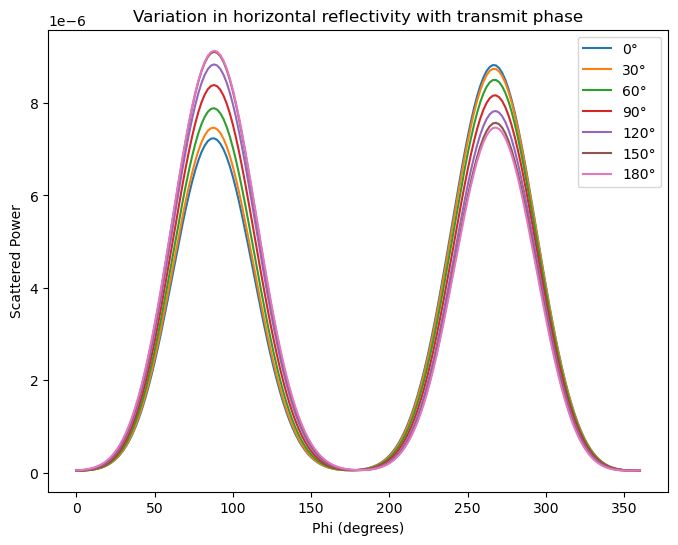

In [10]:
plot_transmit_phase_variation('ZH', title='Variation in horizontal reflectivity with transmit phase', ylabel='Scattered Power')

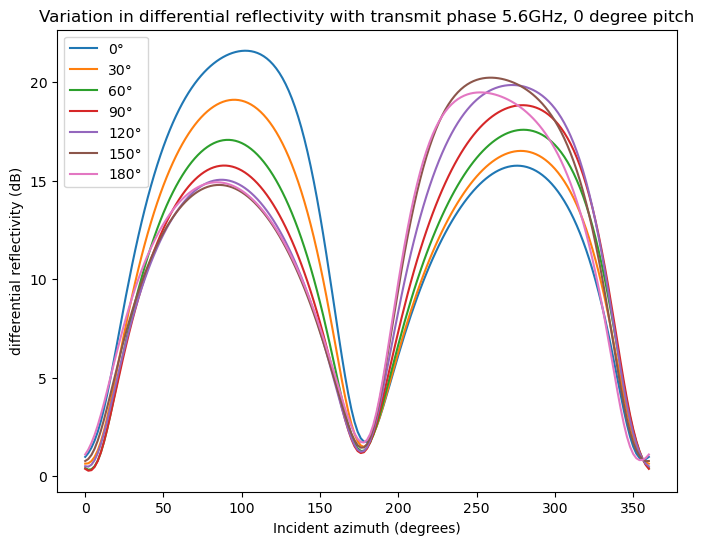

In [33]:
plot_transmit_phase_variation('ZDR', title='Variation in differential reflectivity with transmit phase 5.6GHz, 0 degree pitch', ylabel='differential reflectivity (dB)')

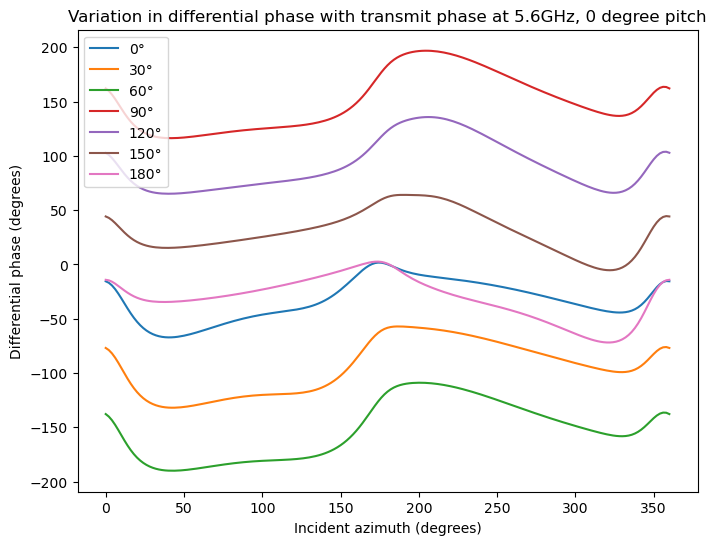

In [32]:
plot_transmit_phase_variation('PhiDP', title='Variation in differential phase with transmit phase at 5.6GHz, 0 degree pitch', ylabel='Differential phase (degrees)')

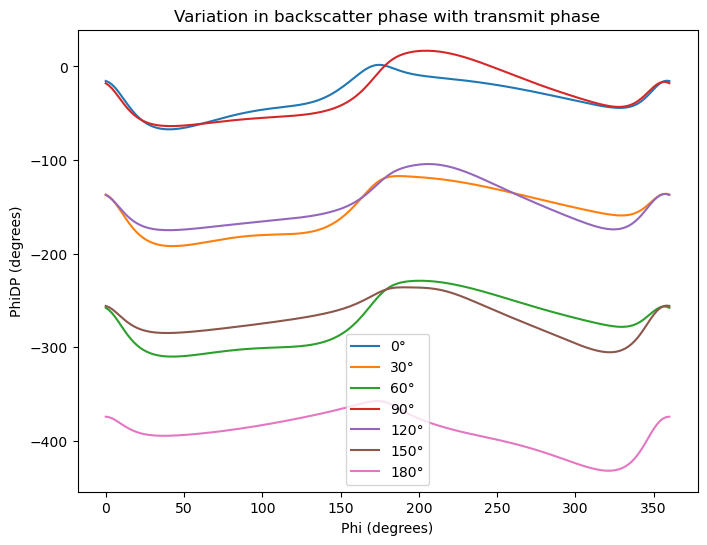

In [13]:
plot_transmit_phase_variation('Backscatter Phase', title='Variation in backscatter phase with transmit phase', ylabel='PhiDP (degrees)')

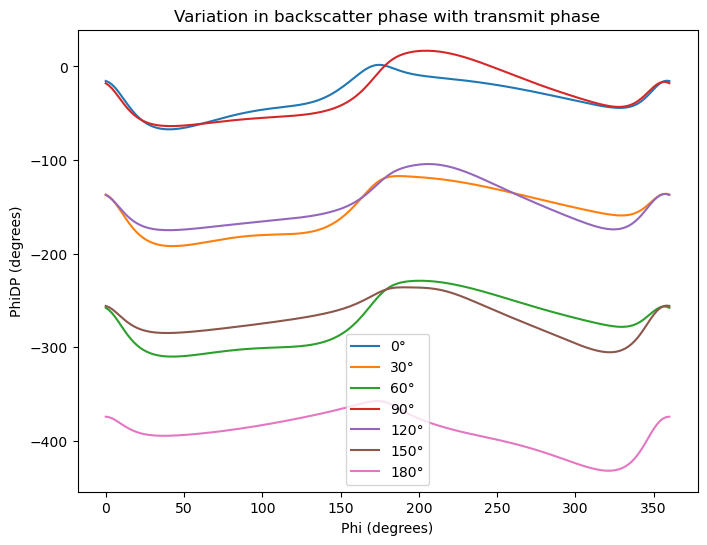

In [14]:
plot_transmit_phase_variation('unwrapped_bs', title='Variation in backscatter phase with transmit phase', ylabel='PhiDP (degrees)')

In [15]:
ellipsoid_results_dict = {x : None for x in pol_list}

for pol in pol_list:
        
        path = BASE_DRIVE_PATH + ELLIPSOID_PATH + f'parameterised/csv/Ellipsoid_parameterised_{frequency_name}_{pol}_{scale}_p0_s0__df.csv'
        ellipsoid_results_dict[pol] = pd.read_csv(path)

In [16]:
edp_obj_dict =  {x : None for x in phi_T_list}

for deg, rad in phi_T_dict.items():
    edp_obj_dict[deg] = ModDualPol(ellipsoid_results_dict['H'], ellipsoid_results_dict['V'], read_from_df=True,transmit_phase_diff=rad)

eresults_dict = {x : {y : None for y in vars_list} for x in phi_T_list}

for phi_T_deg in phi_T_list:
    edp_obj_dict[phi_T_deg]._calculate_differential_reflectivity()
    edp_obj_dict[phi_T_deg]._calculate_differential_phase(de_alias=True)
    edp_obj_dict[phi_T_deg]._calculate_backscatter_phase()
    
    eresults_dict[phi_T_deg]['ZH'] = np.abs(edp_obj_dict[phi_T_deg].resultant_phi_field)**2
    eresults_dict[phi_T_deg]['ZV'] = np.abs(edp_obj_dict[phi_T_deg].resultant_theta_field)**2
    eresults_dict[phi_T_deg]['ZDR'] = edp_obj_dict[phi_T_deg].differential_reflectivity
    eresults_dict[phi_T_deg]['PhiDP'] = edp_obj_dict[phi_T_deg].differential_phase
    eresults_dict[phi_T_deg]['Backscatter Phase'] = edp_obj_dict[phi_T_deg].backscatter_phase

In [17]:
edp_obj_dict[0].resultant_phi_field[0],edp_obj_dict[0].horizontal_data['Ephi'].astype(complex).to_numpy()[0], edp_obj_dict[0].vertical_data['Ephi'].astype(complex).to_numpy()[0]


(np.complex128(0.00025451188258477975+0.00024882067454210936j),
 np.complex128(0.000254511820813742+0.000248820748189772j),
 np.complex128(6.17710376963331e-11-7.36476626349517e-11j))

In [18]:
def plot_transmit_phase_variation_ellipsoid(variable, title=None, ylabel=None):
    plt.figure(figsize=(8, 6))
    for phi_T_deg in phi_T_list:
        plt.plot(H_B['phi'], eresults_dict[phi_T_deg][variable], label=f"Transmit Phase: {phi_T_deg}°")
    plt.xlabel('Phi (degrees)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

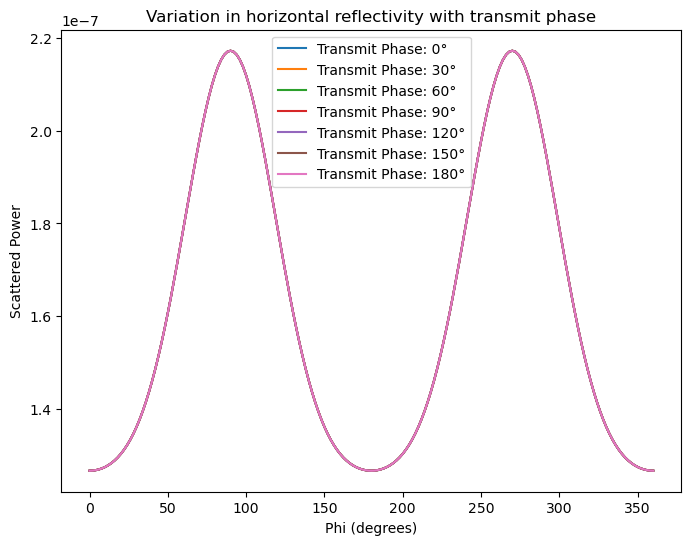

In [19]:
plot_transmit_phase_variation_ellipsoid('ZV', title='Variation in horizontal reflectivity with transmit phase', ylabel='Scattered Power')

In [20]:
tilted_ellipsoid_results_dict = {x : None for x in pol_list}

for pol in pol_list:

    path = BASE_DRIVE_PATH + ELLIPSOID_PATH + f'parameterised/dict/pitch_slant_analysis/Ellipsoid_parameterised_{560}_{pol}_{scale}_p10_s0_dict.pkl'
    conv = converter.from_pickle(path)
    df = conv.generate_output_df()
    
    output_path = BASE_DRIVE_PATH + ELLIPSOID_PATH + f'parameterised/csv/pitch_slant_analysis/Ellipsoid_parameterised_{560}_{pol}_{scale}_p10_s0_df.csv'
    df.to_csv(output_path)
    tilted_ellipsoid_results_dict[pol] = df

In [21]:
tilted_ellipsoid_obj_dict =  {x : None for x in phi_T_list}

for deg, rad in phi_T_dict.items():
    tilted_ellipsoid_obj_dict[deg] = ModDualPol(tilted_ellipsoid_results_dict['H'], tilted_ellipsoid_results_dict['V'], read_from_df=True,transmit_phase_diff=rad)

tilted_ellipsoid_transmit_phase_dict = {x : {y : None for y in vars_list} for x in phi_T_list}

for phi_T_deg in phi_T_list:
    tilted_ellipsoid_obj_dict[phi_T_deg]._calculate_differential_reflectivity()
    tilted_ellipsoid_obj_dict[phi_T_deg]._calculate_differential_phase(de_alias=True)
    tilted_ellipsoid_obj_dict[phi_T_deg]._calculate_backscatter_phase()
    
    tilted_ellipsoid_transmit_phase_dict[phi_T_deg]['ZH'] = np.abs(tilted_ellipsoid_obj_dict[phi_T_deg].resultant_phi_field)**2
    tilted_ellipsoid_transmit_phase_dict[phi_T_deg]['ZV'] = np.abs(tilted_ellipsoid_obj_dict[phi_T_deg].resultant_theta_field)**2
    tilted_ellipsoid_transmit_phase_dict[phi_T_deg]['ZDR'] = tilted_ellipsoid_obj_dict[phi_T_deg].differential_reflectivity
    tilted_ellipsoid_transmit_phase_dict[phi_T_deg]['PhiDP'] = tilted_ellipsoid_obj_dict[phi_T_deg].differential_phase
    tilted_ellipsoid_transmit_phase_dict[phi_T_deg]['Backscatter Phase'] = tilted_ellipsoid_obj_dict[phi_T_deg].backscatter_phase

In [22]:
def plot_transmit_phase_variation_tilted_ellipsoid(variable, title=None, ylabel=None):
    plt.figure(figsize=(8, 6))
    for phi_T_deg in phi_T_list:
        plt.plot(H_B['phi'], tilted_ellipsoid_transmit_phase_dict[phi_T_deg][variable], label=f"Transmit Phase: {phi_T_deg}°")
    plt.xlabel('Phi (degrees)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

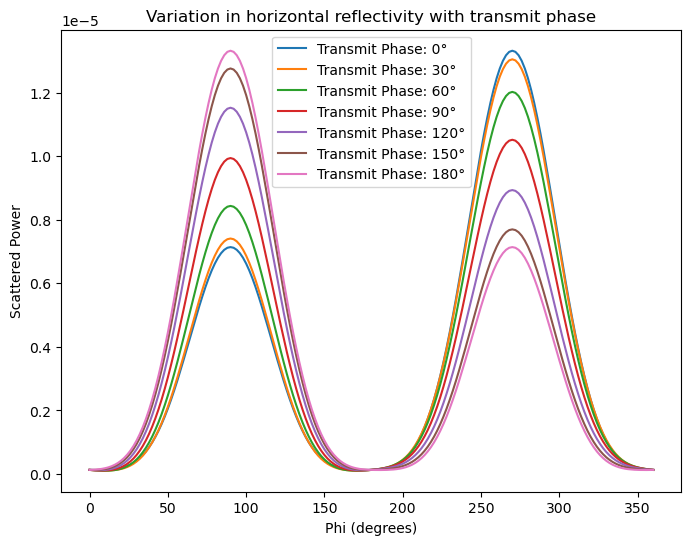

In [23]:
plot_transmit_phase_variation_tilted_ellipsoid('ZH', title='Variation in horizontal reflectivity with transmit phase', ylabel='Scattered Power')

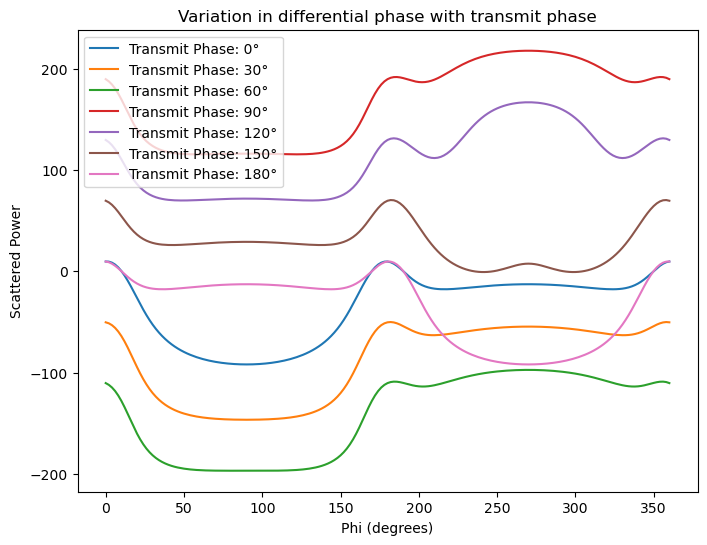

In [24]:
plot_transmit_phase_variation_tilted_ellipsoid('PhiDP', title='Variation in differential phase with transmit phase', ylabel='Scattered Power')

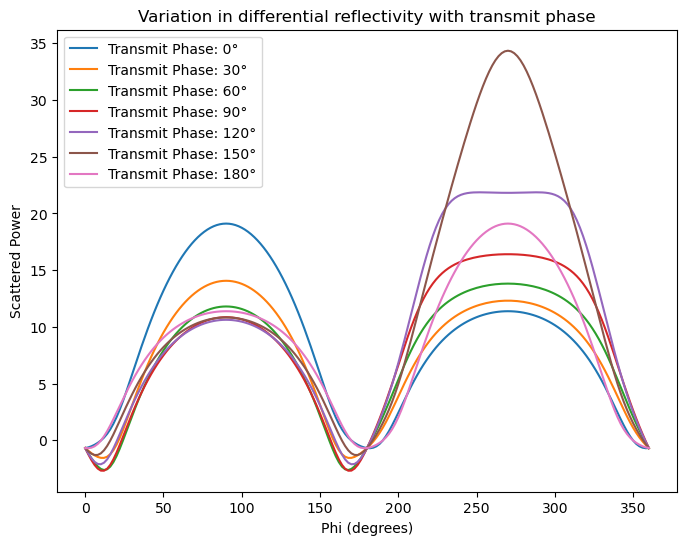

In [25]:
plot_transmit_phase_variation_tilted_ellipsoid('ZDR', title='Variation in differential reflectivity with transmit phase', ylabel='Scattered Power')